# Mapping UK data sets

Import dependencies and create the Spark context

In [1]:
from __future__ import print_function

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, struct, count, col, isnan, when, year, month
from pyspark.sql.types import BooleanType, IntegerType, FloatType, DateType, StringType

import os
import sys
from datetime import datetime
if sys.version_info.major == 2:
    from pathlib2 import Path
else:
    from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
import pyproj
import shapefile as shp
from matplotlib import pyplot as plt
from matplotlib import colorbar, colors
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon, Rectangle
from matplotlib.text import Annotation
from tabulate import tabulate

plt.rcParams['figure.dpi'] = 100

spark = SparkSession.builder.appName("uk_data_mapping").config(conf=SparkConf()).getOrCreate()

Current Spark configuration

In [2]:
sc = SparkContext.getOrCreate()
sc._conf.getAll()

[('spark.driver.host', '192.168.1.8'),
 ('spark.default.parallelism', '64'),
 ('spark.executor.id', 'driver'),
 ('spark.task.maxFailures', '1'),
 ('spark.driver.memory', '1g'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.pyspark.python', '/usr/bin/python3.6'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.local.dir', '/media/csk13/d/scratch'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1540752573970'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '33205'),
 ('spark.ui.showConsoleProgress', 'true')]

---

## Ordinance Survey Boundary-Line data set
The boundary line data set contains `.shp` _shapefiles_ which store the shapes of various UK administrative regions along with data associated with each region. The data set is freely available and can be [downloaded](https://www.ordnancesurvey.co.uk/business-and-government/products/boundary-line.html) from the ordinance survey website.

In [3]:
!tree ${DATA_BDLINE}/Data/GB

/home/csk13/src/uk-data-mapping/bdline/Data/GB
├── county_electoral_division_region.dbf
├── county_electoral_division_region.prj
├── county_electoral_division_region.shp
├── county_electoral_division_region.shx
├── county_region.dbf
├── county_region.prj
├── county_region.shp
├── county_region.shx
├── district_borough_unitary_region.dbf
├── district_borough_unitary_region.prj
├── district_borough_unitary_region.shp
├── district_borough_unitary_region.shx
├── district_borough_unitary_ward_region.dbf
├── district_borough_unitary_ward_region.prj
├── district_borough_unitary_ward_region.shp
├── district_borough_unitary_ward_region.shx
├── european_region_region.dbf
├── european_region_region.prj
├── european_region_region.shp
├── european_region_region.shx
├── greater_london_const_region.dbf
├── greater_london_const_region.prj
├── greater_london_const_region.shp
├── greater_london_const_region.shx
├── high_water_polyline.dbf
├── high_water_polyline.prj
├── high_water_polyline.shp
├── high_

Let's take a look at the `district_borough_unitary_region` data set

In [4]:
BDLINE_DIR = os.getenv('DATA_BDLINE')
BDLINE_DISTRICT_CSV = os.path.join(BDLINE_DIR, 'Data/GB/district_borough_unitary_region.shp')
BDLINE_COUNTY_CSV = os.path.join(BDLINE_DIR, 'Data/Supplementary_Ceremonial/Boundary-line-ceremonial-counties_region.shp')
BDLINE_LONDON_CSV = os.path.join(BDLINE_DIR, 'Data/GB/greater_london_const_region.shp')

In [5]:
sf_district = shp.Reader(BDLINE_DISTRICT_CSV)

Available fields in the shapefile data

In [6]:
sf_district.fields

[('DeletionFlag', 'C', 1, 0),
 ['NAME', 'C', 60, 0],
 ['AREA_CODE', 'C', 3, 0],
 ['DESCRIPTIO', 'C', 50, 0],
 ['FILE_NAME', 'C', 50, 0],
 ['NUMBER', 'N', 11, 0],
 ['NUMBER0', 'N', 11, 0],
 ['POLYGON_ID', 'N', 11, 0],
 ['UNIT_ID', 'N', 11, 0],
 ['CODE', 'C', 9, 0],
 ['HECTARES', 'N', 12, 3],
 ['AREA', 'N', 12, 3],
 ['TYPE_CODE', 'C', 2, 0],
 ['DESCRIPT0', 'C', 25, 0],
 ['TYPE_COD0', 'C', 3, 0],
 ['DESCRIPT1', 'C', 36, 0]]

Number of records

In [7]:
sf_district.numRecords

380

Let's take a look at the first record

In [74]:
sf_district.record(0)  # or sf_district.records()[0]

['Wycombe District',
 'DIS',
 'District',
 'BUCKINGHAMSHIRE_COUNTY',
 5,
 377,
 51844,
 11882,
 'E07000007',
 32457.21,
 0.0,
 'AA',
 'CIVIL ADMINISTRATION AREA',
 '',
 '']

The geometry for each of the districts is defined within the `.shp` file and can be accessed through the `shape` and `shapes` methods. According to the [Boundary-Line User Manual](https://digimap.edina.ac.uk/webhelp/os/data_files/os_manuals/boundary-line-user-guide_1_18.pdf) (p.91), all Ordnance Survey geometry is defined in the OSGB36 projection.

>**National Grid**  
A unique referencing system that can be applied to all Ordnance Survey maps of Great Britain (GB) at all
scales. It is used by Ordnance Survey on all post-war mapping to provide an unambiguous spatial reference
in Great Britain for any place or entity whatever the map scale. The National Grid is defined by the OSGB36®
spheroid.

In [9]:
sf_district.shape(0).points[:5]

[(476152.20059080864, 183567.80351806417),
 (476146.50325358775, 183569.70297435045),
 (476164.7990441711, 183643.40187825868),
 (476191.10078908363, 183743.60319592984),
 (476205.4966657661, 183806.2952505159)]

Some shapes contain multiple components so care must be taken to draw each as a separate closed polygon. For multi-part shapes, the list `parts` will contain multiple offsets which indicate the location of the first point in the corresponding `points` array.

In [10]:
sf_district.shape(5).parts

[0, 6570]

It is necesary to map district codes to the associated shp record

In [11]:
district_to_shp_record_map = {
    x[8]: i for i, x in enumerate(sf_district.records())
}

---

## UK HM Land Registry Price Paid data set

Data on the price paid for houses in England and Wales from 1995 to present can be [downloaded](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads) for free from HM Land Registry. Details about the data including a description of the fields are available [here](https://www.gov.uk/guidance/about-the-price-paid-data).

It is stated that data from the most recent 2 months is **not reliable** due to the typical time of between 2 weeks and 2 months between the sale of a property and registration.

>The amount of time between the sale of a property and the registration of this information with HM Land Registry varies. It typically ranges between 2 weeks and 2 months. Data for the two most recent months is therefore incomplete and does not give an indication of final monthly volumes. 

In [14]:
PP_CSV = os.getenv('DATA_PP_COMPLETE')

Let's take a look at the first few entries in the data set

In [15]:
!head -3 $PP_CSV

"{BC7C2FC5-6B3D-41DF-981E-D02E70CBE6C3}","62750","1995-10-31 00:00","BS6 7TF","T","Y","F","59","","THE FURLONG","BRISTOL","BRISTOL","BRISTOL","AVON","A","A"
"{BF52C772-ED3F-485E-83CF-CCA3C3F5F3B5}","175000","1995-10-27 00:00","NE20 9PH","D","Y","F","14","","OAKLANDS","PONTELAND","NEWCASTLE UPON TYNE","CASTLE MORPETH","NORTHUMBERLAND","A","A"
"{752C4832-3E46-4BC1-9360-D3B5DFE358D8}","15000","1995-04-21 00:00","WV2 4NY","T","N","F","40","","ARGYLE ROAD","WOLVERHAMPTON","WOLVERHAMPTON","WOLVERHAMPTON","WEST MIDLANDS","A","A"


### Loading the data into python
The dataset is approximately 4GB in size, and although this is not very big, it's big enough to be problematic to work with. Attempting to load all of the data into a Pandas DataFrame exhausts all system memory. Instead the data can be loaded into a Spark data frame.

In [16]:
%%time
pp = spark.read.csv(PP_CSV, header=False, inferSchema=True)

CPU times: user 19.6 ms, sys: 10.9 ms, total: 30.4 ms
Wall time: 1min 47s


Number of rows in the dataset

In [17]:
%%time
# 64 partitions
pp.count()

CPU times: user 3.35 ms, sys: 0 ns, total: 3.35 ms
Wall time: 13.6 s


22859090

The dataset does not contain column names so these must be added manually based on the information found through the link above.

In [18]:
col_names = {
    0: 'id',
    1: 'price',
    2: 'date_of_transfer',
    3: 'postcode',
    4: 'property_type',
    5: 'is_new',
    6: 'duration',
    7: 'PAON',
    8: 'SAON',
    9: 'street',
    10: 'locality',
    11: 'town_city',
    12: 'district',
    13: 'county',
    14: 'ppd_category_type',
    15: 'record_status',
}

col_name_list = [
    v for k, v in sorted(
        [(k, v) for k, v in col_names.items()], key=lambda x: x[0]
    )
]

Rename all the columns in the dataframe

In [19]:
%%time
# 64 partitions
pp = pp.toDF(*col_name_list)

CPU times: user 6.3 ms, sys: 0 ns, total: 6.3 ms
Wall time: 41.6 ms


Display the schema for the dataframe - field names, types

In [20]:
pp.printSchema()

root
 |-- id: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- date_of_transfer: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- is_new: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- PAON: string (nullable = true)
 |-- SAON: string (nullable = true)
 |-- street: string (nullable = true)
 |-- locality: string (nullable = true)
 |-- town_city: string (nullable = true)
 |-- district: string (nullable = true)
 |-- county: string (nullable = true)
 |-- ppd_category_type: string (nullable = true)
 |-- record_status: string (nullable = true)



Any records with missing postcodes must be removed.

In [23]:
pp = pp.dropna(subset=['postcode'])

Take a sample of the data set as this will be quicker for exploratory work.

In [24]:
%%time
# 64 partitions?
pp.count()

CPU times: user 1.73 ms, sys: 719 µs, total: 2.45 ms
Wall time: 15.4 s


22830337

Let's take a look at a few randomly selected entries in the data set to see what we're working with

In [25]:
pprint([row.asDict() for row in pp.rdd.take(2)])

[{'PAON': '59',
  'SAON': None,
  'county': 'AVON',
  'date_of_transfer': '1995-10-31 00:00',
  'district': 'BRISTOL',
  'duration': 'F',
  'id': '{BC7C2FC5-6B3D-41DF-981E-D02E70CBE6C3}',
  'is_new': 'Y',
  'locality': 'BRISTOL',
  'postcode': 'BS6 7TF',
  'ppd_category_type': 'A',
  'price': 62750,
  'property_type': 'T',
  'record_status': 'A',
  'street': 'THE FURLONG',
  'town_city': 'BRISTOL'},
 {'PAON': '14',
  'SAON': None,
  'county': 'NORTHUMBERLAND',
  'date_of_transfer': '1995-10-27 00:00',
  'district': 'CASTLE MORPETH',
  'duration': 'F',
  'id': '{BF52C772-ED3F-485E-83CF-CCA3C3F5F3B5}',
  'is_new': 'Y',
  'locality': 'PONTELAND',
  'postcode': 'NE20 9PH',
  'ppd_category_type': 'A',
  'price': 175000,
  'property_type': 'D',
  'record_status': 'A',
  'street': 'OAKLANDS',
  'town_city': 'NEWCASTLE UPON TYNE'}]


The `date_of_transfer` field is a string specifying the date at which the sale took place. This needs to be converted to a `datetime` object (`spark.sql.types.DateType`) in order to manipulate it as a date.

In [26]:
%%time

def date_str_to_datetime(date_str, datetime_format='%Y-%m-%d %H:%M'):
    try:
        return datetime.strptime(date_str, datetime_format).date()
    except Exception:
        return
    
pp = pp.withColumn(
    'date_of_transfer_datetime',
    udf(lambda x: date_str_to_datetime(x), DateType())(pp['date_of_transfer'])
).dropna(subset=['date_of_transfer_datetime'])

CPU times: user 18 ms, sys: 3.27 ms, total: 21.3 ms
Wall time: 187 ms


### House sale volume by year

Now we can see how many sales took place each year.

In [27]:
%%time
# 64 partitions
sales_by_year = pp.groupby(year(pp['date_of_transfer_datetime']).alias('year')).count().orderBy('year').toPandas()
sales_by_year = sales_by_year.iloc[:-1]  # Trim last year with incomplete data

CPU times: user 61.3 ms, sys: 16.5 ms, total: 77.8 ms
Wall time: 2min 18s


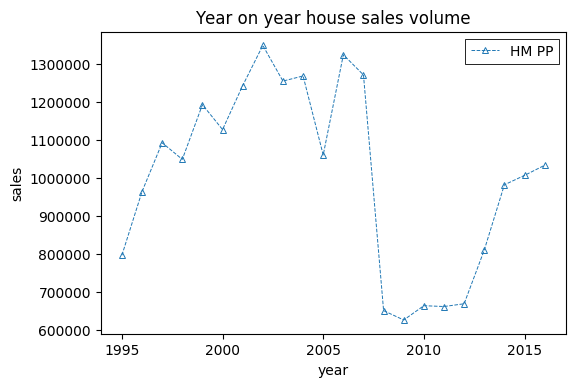

In [28]:
plt.rcParams['figure.dpi'] = 100
plt.plot(sales_by_year['year'], sales_by_year['count'], linestyle='--', marker='^', 
         markerfacecolor='none', markeredgewidth=0.7, label=r'HM PP')
plt.legend()
plt.title('Year on year house sales volume')
plt.xlabel('year')
plt.ylabel('sales')
plt.show()

---

## Mapping post codes into map tile regions
The code point open data set includes details of which county each UK postcode belongs. The data is freely available for [download](https://www.ordnancesurvey.co.uk/business-and-government/products/code-point-open.html) from Ordinance Survey.

In [29]:
CPO_DIR = os.getenv('DATA_CODEPO')

In [30]:
!tree $CPO_DIR | head -10

/home/csk13/src/uk-data-mapping/codepo_gb
├── Data
│   └── CSV
│       ├── ab.csv
│       ├── al.csv
│       ├── ba.csv
│       ├── bb.csv
│       ├── b.csv
│       ├── bd.csv
│       ├── bh.csv


The postcode data is split into many `.csv` files, each one named based on the [postcode area code](https://en.wikipedia.org/wiki/List_of_postcode_areas_in_the_United_Kingdom) - the first one or two letters of the post code.

A file specifying the column headers is provided. Let's take a look.

In [31]:
!head $CPO_DIR/Doc/Code-Point_Open_Column_Headers.csv

PC,PQ,EA,NO,CY,RH,LH,CC,DC,WC
Postcode,Positional_quality_indicator,Eastings,Northings,Country_code,NHS_regional_HA_code,NHS_HA_code,Admin_county_code,Admin_district_code,Admin_ward_code


Let's take a look at a few entries from one of the .csv files

In [32]:
!head -3 $CPO_DIR/Data/CSV/ab.csv

"AB101AB",10,394235,806529,"S92000003","","S08000020","","S12000033","S13002842"
"AB101AF",10,394181,806429,"S92000003","","S08000020","","S12000033","S13002842"
"AB101AG",10,394230,806469,"S92000003","","S08000020","","S12000033","S13002842"


Building mapping between postcode and district code.

In [40]:
%%time
postarea_code_fnames = [str(path) for path in (Path(CPO_DIR) / 'Data/CSV').glob('*.csv')]

postcode_to_district_map = {
    x[1].replace(' ', '').upper(): x[2] 
    for fname in postarea_code_fnames 
    for x in pd.read_csv(fname, usecols=(0,8,), header=None).itertuples()
}

CPU times: user 2.67 s, sys: 127 ms, total: 2.8 s
Wall time: 2.84 s


In [41]:
len(postcode_to_district_map)

1698194

---

## Mean house prices by district

The postcodes in the Code Point Open dataset and the Price Paid dataset are in different formats. It's necessary to remove spaces from the postcodes in the Price Paid dataset.

In [47]:
pp = pp.withColumn('postcode', udf(lambda x: x.replace(' ', '').upper(), StringType())(pp['postcode']))

In order to aggregate data at the district level we first need to assign each row to a district using the mapping defined by `postcode_to_district_map`.

In [169]:
pp = pp.withColumn(
    'district_id', udf(postcode_to_district_map.get, StringType())(pp['postcode'])
).dropna(subset=['district_id'])

Create a Pandas DataFrame containing the mean sale price for each year and district

In [115]:
mean_prices = pp.groupby([year(pp['date_of_transfer_datetime']).alias('year'), 'district_id'])\
                .agg({'price': 'mean'})\
                .withColumnRenamed('avg(price)', 'price_mean')\
                .toPandas()
mean_prices.set_index(['year', 'district_id'], inplace=True)

In [213]:
def filter_districts(district):
    """Returns True if district is in England or Wales else False."""
    return district.upper().startswith('E') or district.upper().startswith('W')

mean_prices = mean_prices[mean_prices.index.map(lambda x: filter_districts(x[1]))]

---
### Plotting map

Dictionary to isolate London districts.

In [122]:
LONDON_POSTCODES_CSV = os.getenv('DATA_LONDON_POSTCODES')
london_districts_df = pd.read_csv(LONDON_POSTCODES_CSV, usecols=(10,))
london_districts = {x: None for x in london_districts_df['District Code'].unique()}
sf_london_idx = np.array([i for i, rec in enumerate(sf_district.records()) if rec[8] in london_districts])
assert len(sf_london_idx) == len(london_districts)

The `pyproj` package is useful for converting between geographic projections. Projection formats are specified by [ESPG codes](http://spatialreference.org/).

In [64]:
wgs84=pyproj.Proj("+init=EPSG:4326")     # LatLon with WGS84 datum used by GPS units and Google Earth
osgb36 = pyproj.Proj("+init=EPSG:27700") # UK Ordnance Survey, 1936 datum

London_LonLat = (-0.1278, 51.5074)        # Lon-Lat geospatial coords for London
London_osgb36 = osgb36(*London_LonLat)   # Lon-Lat OS National Grid coords for London

OSGB36 Coords of the top10 UK cities by population. List of UK cities by population is available [here](http://www.citymayors.com/gratis/uk_topcities.html). WGS84 Lat-Long coordinates were obtained from Google Maps. It is important to note that **positive latitude** specifies and angle **North** of the equator and **positive longitude** specifies an angle **East** of the prime meridian.

In [65]:
uk_cities_top10_wgs84 = {
    'London': [(51.5074, -0.1278), (50.523194, 0.355571)],
    'Birmingham': [(52.4862, -1.8904), (50.253231, -1.88417)],
    'Leeds': [(53.8008, -1.5491), (54.775133, -0.875307)],
    'Glasgow': [(55.8642, -4.2518), (54.846665, -7.336002)],
    'Sheffield': [(53.3811, -1.4701), (53.150688, 0.603948)],
    'Bradford': [(53.7960, -1.7594), (55.177306, -1.134410)],
    'Liverpool': [(53.4084, -2.9916), (53.597492, -5.146998)],
    'Edinburgh': [(55.9533, -3.1883), (56.308727, -2.116987)],
    'Manchester': [(53.4808, -2.2426), (54.004974, -5.715788)],
    'Bristol': [(51.4545, -2.5879), (50.149561, -3.247066)],
}

uk_cities_top10_osgb36 = {
    k: osgb36(lon, lat) 
    for k, ((lat, lon), _) in uk_cities_top10_wgs84.items()
}
uk_cities_top10_labels_osgb36 = {
    k: osgb36(lon, lat) 
    for k, (_, (lat, lon)) in uk_cities_top10_wgs84.items()
}

In [66]:
uk_cities_top10_osgb36

{'London': (529915.8259598681, 180433.9938870187),
 'Birmingham': (407441.59663470316, 287633.45594173216),
 'Leeds': (429694.25737852394, 433951.22248979274),
 'Glasgow': (259095.16632049525, 665735.5205742274),
 'Sheffield': (435244.32054710225, 387299.03216908325),
 'Bradford': (415846.6846645916, 433349.79639267735),
 'Liverpool': (334090.2975010383, 390663.0040515137),
 'Edinburgh': (325808.153663839, 673996.2847710882),
 'Manchester': (383902.0295161803, 398286.245722139),
 'Bristol': (359155.7086262001, 173053.65671517007)}

Functions for plotting shapefile with districts coloured by mean price

In [299]:
def create_shp_patches(sf):
    """Returns tuple containing UK and London patches for shapefile `sf`."""
    # Create list of polygon patches for all districts
    patches_uk = []
    for i, shape in enumerate(sf.shapes()):
        for points in np.split(np.array(shape.points), shape.parts)[1:]:
            polygon = Polygon(points, closed=True)
            patches_uk.append(polygon)

    # Create list of polygon patches for London districts
    patches_ldn = []
    scale = 5.
    trans = np.array([-2.7e6, -6.0e5])
    for idx in sf_london_idx:
        for points in np.split(np.array(sf.shape(idx).points), sf.shape(idx).parts)[1:]:
            points *= scale  # Increase size of London districts
            points += trans  # Shift London districts
            polygon = Polygon(points, closed=True)
            patches_ldn.append(polygon)

    return (patches_uk, patches_ldn)


def plot_map_for_year(year, fname=None):
    mean_price_year = np.array([
        mean_prices.loc[year, rec[8]].price_mean if rec[8] in mean_prices.loc[year].index else 0.
        for rec in sf_district.records()
    ])

    fig, ax = plt.subplots(1, figsize=(4, 4))
    ax.set_aspect('equal')  # Need equal aspect ratio to prevent skewed geometry
    plt.axis('off')
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)

    # Set plot colormap and colours
    log_mean_price_year = np.where(mean_price_year > 0., np.log10(mean_price_year), 0.)
    vmin, vmax = np.log10(8.0e4), np.log10(2.0e6)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap('plasma')

    # Create patches from shp file
    patches, patches_ldn = create_shp_patches(sf_district)

    # Set colours for UK patches
    colours = []
    for i, shape in enumerate(sf_district.shapes()):
        for points in np.split(np.array(shape.points), shape.parts)[1:]:
            colour = cmap(norm(log_mean_price_year[i])) if log_mean_price_year[i] > 0. \
                else np.array([0.85, 0.85, 0.85, 1.])
            colours.append(colour)

    collection = PatchCollection(patches)
    collection.set_facecolor(colours)
    collection.set_linewidths(0.1)
    ax.add_collection(collection)

    # Set colours for London patches
    colours_ldn = []
    for idx in sf_london_idx:
        for points in np.split(np.array(sf_district.shape(idx).points), sf_district.shape(idx).parts)[1:]:
            colour = cmap(norm(log_mean_price_year[idx])) if log_mean_price_year[idx] > 0. \
                else np.array([0.85, 0.85, 0.85, 1.])
            colours_ldn.append(colour)

    collection_ldn = PatchCollection(patches_ldn)
    collection_ldn.set_facecolor(colours_ldn)
    collection_ldn.set_linewidths(0.1)
    ax.add_collection(collection_ldn)

    # Add boxes around London
    pos_lg, w_lg, h_lg = np.array([-2.e5, 1.6e5]), 3.2e5, 2.6e5
    pos_sm, w_sm, h_sm = (pos_lg - trans) / scale, w_lg / scale, h_lg / scale 
    rect_lg = Rectangle(pos_lg, w_lg, h_lg, angle=0.0, fill=False, linewidth=0.4, color='r')
    rect_sm = Rectangle(pos_sm, w_sm, h_sm, angle=0.0, fill=False, linewidth=0.4, color='r', zorder=10)
    ax.add_patch(rect_lg)
    ax.add_patch(rect_sm)

    ax.set_xlim((-3.e5, 8.0e5)) # Manually tune layout width...
    ax.set_ylim((-0., 1.22e6))  # ...and height.
    #ax.autoscale_view()

    # Create colorbar independent of plot elements 
    cax = fig.add_axes([0.75, 0.4, 0.01, 0.2])
    cbar = colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, ticks=np.log10([1.0e5, 5.0e5, 1.5e6]))
    cbar.ax.set_yticklabels(['0.1', '0.5', '1.5'])
    cbar.set_label(u'Mean price (M\u00a3)', fontsize=5)
    cbar.ax.tick_params(labelsize=4)

    # Add points indicating 10 biggest cities
    for label, (x, y) in uk_cities_top10_osgb36.items():
        ax.scatter(x, y, label=label, c='black', s=2.)

    for label, (xy, xytext) in uk_cities_top10_wgs84.items():
        ax.annotate(label, xy=osgb36(xy[1], xy[0]), xytext=osgb36(xytext[1], xytext[0]), xycoords='data',
                    fontsize=3, horizontalalignment='left', verticalalignment='bottom', 
                    arrowprops=dict(color='black', shrink=0., width=0.05, headwidth=0.05, headlength=0.05))

    ax.text(0.0, 0.85, 'UK House Prices', transform=ax.transAxes, fontsize=12)
    ax.text(0.0, 0.78, f'Year: {year}', transform=ax.transAxes, fontsize=9)

    plt.draw()
    plt.savefig(f'plot/mean-price-map-{year}.png', dpi=600, bbox_inches='tight', pad_inches=0.1)

Create directory to store plots

In [193]:
!mkdir -p plot

Save plots to disk for all years

In [296]:
years = mean_prices.index.levels[0]
for year in years:
    plot_map_for_year(year)
    plt.close();

/home/csk13/src/uk-data-mapping/venv/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log10


Create gif animation (requires `convert` and `gifsicle`)

In [297]:
!for f in $(ls -d plot/*.png); do convert $f ${f%.png*}.gif; done
!gifsicle --colors 256 --delay=100 --loop $(ls plot/*.gif | sort -g) > plot/mean-price-map-anim.gif

Show plot for 2016

/home/csk13/src/uk-data-mapping/venv/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log10


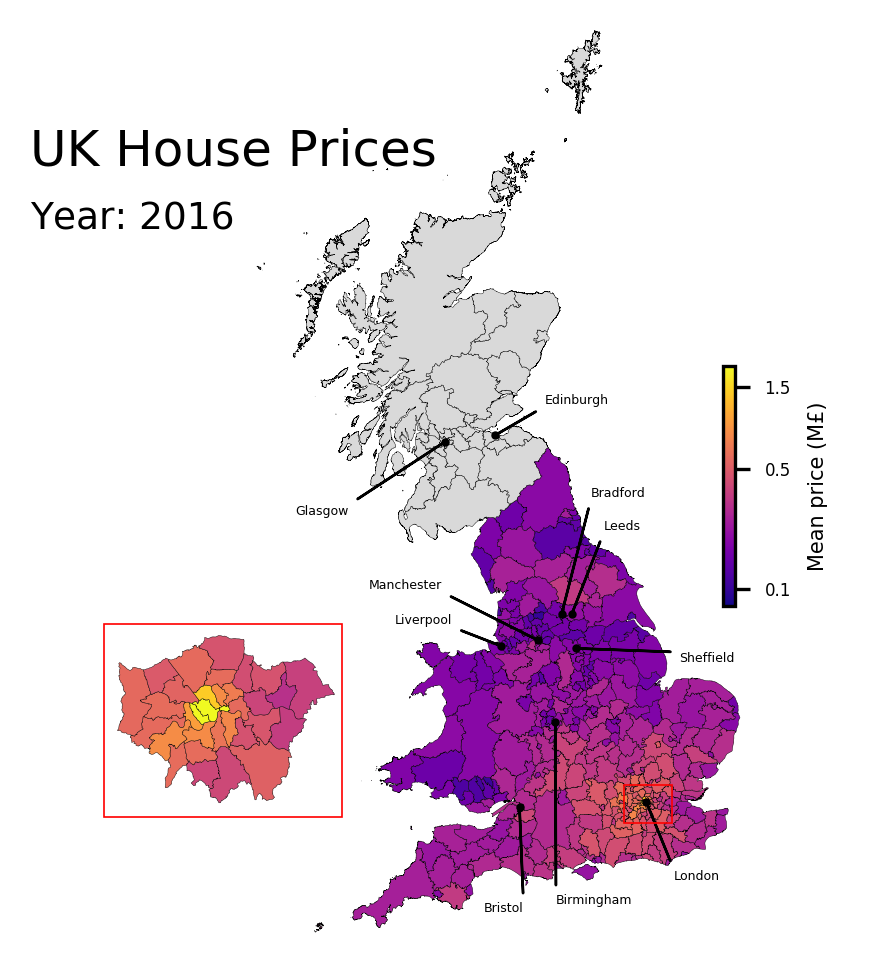

In [293]:
plt.rcParams['figure.dpi'] = 300
plot_map_for_year(2016)
plt.show()

**TODO**
- ~~Figure out why there are so many null values in the mean price data and fix.~~ (Was caused by bug in postcode mapping)
- PP dataset only includes England and Wales. Scotland and NI data?
- Show only mainland UK districts.
- ~~Resize colorbar and display labels in £.~~
- Decide optimal value range for colorbar. Extremes in data reduce colour variation so should be clipped.
- ~~Add inset showing London~~
- ~~Add labelled dots showing [UK top cities by population](http://www.citymayors.com/gratis/uk_topcities.html).~~
- ~~Add title indicating year in each plot.~~
- Adjust house prices for inflation
- Show house prices relative to median income for 30-35 year olds adjusted for inflation
- ~~Remove district on Scottish boarder which only occurs in a subset of years.~~
- Add population, GDP per capita and unemployment rate to plot
- Run for full dataset. Produce a single graph for each year using consistent colour normalisation.